### Introduction to statistical learning with R done in Python

In [78]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import io
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 100000000)
pd.set_option('display.max_columns', 100000000)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### 4.6 Lab: Logistic Regression, LDA, QDA, and KNN

We will begin by examining some numerical and graphical summaries of
the Smarket data, which is part of the ISLR library. This data set consists of
percentage returns for the S&P 500 stock index over 1, 250 days, from the
beginning of 2001 until the end of 2005. For each date, we have recorded
the percentage returns for each of the five previous trading days, Lag1
through Lag5. We have also recorded Volume (the number of shares traded on the previous day, in billions), Today (the percentage return on the date
in question) and Direction (whether the market was Up or Down on this
date).

In [49]:
path = 'C:/Users/Schindler/Documents/ProgrammingFun/Books/ISLR/Smarket.csv'

data_Smkt = pd.read_csv(path)
data_Smkt = pd.DataFrame(data_Smkt)
data_Smkt.drop('Unnamed: 0', axis=1, inplace=True)
print(data_Smkt.shape)
print(data_Smkt.columns.values)
data_Smkt.head()

(1250, 9)
['Year' 'Lag1' 'Lag2' 'Lag3' 'Lag4' 'Lag5' 'Volume' 'Today' 'Direction']


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [50]:
data_Smkt.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [51]:
data_Smkt.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


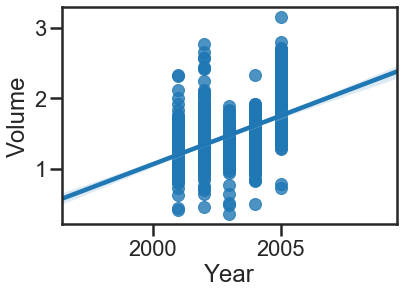

In [52]:
sns.regplot(x='Year', y='Volume', data=data_Smkt)

4.6.2 Logistic Regression

Next, we will fit a logistic regression model in order to predict Direction
using Lag1 through Lag5 and Volume. The glm() function fits generalized
glm()
linear models, a class of models that includes logistic regression. The syntax
generalized
of the glm() function is similar to that of lm(), except that we must pass in linear model
the argument family=binomial in order to tell R to run a logistic regression
rather than some other type of generalized linear model.

In [67]:
import statsmodels.formula.api as smf
data_Smkt['D_code'] = [0 if x=='Down' else 1 for x in data_Smkt['Direction']]
lr = smf.logit(formula='D_code ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', data=data_Smkt).fit()

print(lr.summary(), '\n')
print(lr.resid_dev.describe(), '\n')
print(lr.aic, '\n')

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 D_code   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 May 2020   Pseudo R-squ.:                0.002074
Time:                        12:14:47   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

The predict() function can be used to predict the probability that the
market will go up, given values of the predictors.

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, Up or Down. The following two commands create a vector
of class predictions based on whether the predicted probability of a market
increase is greater than or less than 0.5.

Given these predictions, the table() function
table()
can be used to produce a confusion matrix in order to determine how many
observations were correctly or incorrectly classified.

In [76]:
print(lr.predict()[0:9])
data_Smkt['predict'] = ['Up' if x>0.5 else 'Down' for x in lr.predict()]
data_Smkt[['Direction', 'predict']]
lr.pred_table()

[0.50708413 0.48146788 0.48113883 0.51522236 0.51078116 0.50695646
 0.49265087 0.50922916 0.51761353]


array([[145., 457.],
       [141., 507.]])

In [83]:
#split data
train, test = train_test_split(data_Smkt, test_size = .3, random_state=39)

x_cols = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']

Y_train = train['Direction']
Y_test = test['Direction']

X_train = train[x_cols]
X_test = test[x_cols]

lr = LogisticRegression(random_state=39)

lr.fit(X_train,Y_train)
print(lr.score(X_train,Y_train))
y_pred = lr.predict(X_test)
confusion_matrix(Y_test, y_pred)

0.5291428571428571


array([[ 26, 154],
       [ 28, 167]], dtype=int64)